# Code Implementation w/o pytorch

## Preprocessing
> 이상한 나라의 엘리스 텍스트로 단어 사전을 구축, 단어를 인덱스로 매핑

In [ ]:
import urllib.request

# 텍스트 데이터 다운로드 함수
def download_text(url):
    response = urllib.request.urlopen(url)
    raw = response.read().decode('utf-8')
    return raw

# 샘플 텍스트 데이터 다운로드 (Project Gutenberg의 "Alice's Adventures in Wonderland")
url = 'https://www.gutenberg.org/files/11/11-0.txt'
print("Downloading text data...")
text = download_text(url)
print("Download complete.")

# 단어 단위로 분할
words = text.lower().split()[:1000] # 1,000개 단어만 사용
print(f"Total words: {len(words)}")

# 단어 사전 구축
vocab = sorted(list(set(words)))
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for idx, word in enumerate(vocab)}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# 하이퍼파라미터 설정
embedding_dim = 30 # 임베딩 벡터의 차원
hidden_dim = 100 # 은닉층의 뉴런 수
learning_rate = 0.01 # 학습률
epochs = 3000 # 학습 에포크 수
n = 2 # n-그램의 n 값
batch_size = 32  # 배치 크기

Download complete.
Total words: 1000
Vocabulary size: 463


## 모델 구성
> 임베딩 층, 은닉 층, 출력 층 초기화

In [ ]:
import numpy as np
import math

# Xavier 초기화 함수
def xavier_init(size_in, size_out):
    bound = np.sqrt(6.0) / np.sqrt(size_in + size_out)
    return np.random.uniform(-bound, bound, (size_in, size_out)).astype(np.float64)

# 가중치 초기화 (Xavier 초기화 적용)
E = xavier_init(vocab_size, embedding_dim)       # 임베딩 행렬: V x D
W = xavier_init(n * embedding_dim, hidden_dim)  # 은닉층 가중치: (n*D) x H
b = np.zeros(hidden_dim, dtype=np.float64)      # 은닉층 바이어스: H
V_out = xavier_init(hidden_dim, vocab_size)     # 출력층 가중치: H x V
c = np.zeros(vocab_size, dtype=np.float64)       # 출력층 바이어스: V

# 활성화 함수: ReLU 및 도함수
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(np.float64)

# 소프트맥스 함수
def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)  # 안정성을 위해 최대값을 빼줌
    exps = np.exp(z)
    return exps / np.sum(exps, axis=1, keepdims=True)

## Train

Total training samples: 998
Epoch 1/3000, Loss: 6.1390
Epoch 100/3000, Loss: 5.7460
Epoch 200/3000, Loss: 5.5092
Epoch 300/3000, Loss: 5.4285
Epoch 400/3000, Loss: 5.3029
Epoch 500/3000, Loss: 5.0959
Epoch 600/3000, Loss: 4.7846
Epoch 700/3000, Loss: 4.3535
Epoch 800/3000, Loss: 3.8463
Epoch 900/3000, Loss: 3.3263
Epoch 1000/3000, Loss: 2.7735
Epoch 1100/3000, Loss: 2.2542
Epoch 1200/3000, Loss: 1.7909
Epoch 1300/3000, Loss: 1.3979
Epoch 1400/3000, Loss: 1.0910
Epoch 1500/3000, Loss: 0.8603
Epoch 1600/3000, Loss: 0.6894
Epoch 1700/3000, Loss: 0.5652
Epoch 1800/3000, Loss: 0.4758
Epoch 1900/3000, Loss: 0.4077
Epoch 2000/3000, Loss: 0.3582
Epoch 2100/3000, Loss: 0.3192
Epoch 2200/3000, Loss: 0.2876
Epoch 2300/3000, Loss: 0.2643
Epoch 2400/3000, Loss: 0.2448
Epoch 2500/3000, Loss: 0.2325
Epoch 2600/3000, Loss: 0.2208
Epoch 2700/3000, Loss: 0.2118
Epoch 2800/3000, Loss: 0.2048
Epoch 2900/3000, Loss: 0.1969
Epoch 3000/3000, Loss: 0.1929


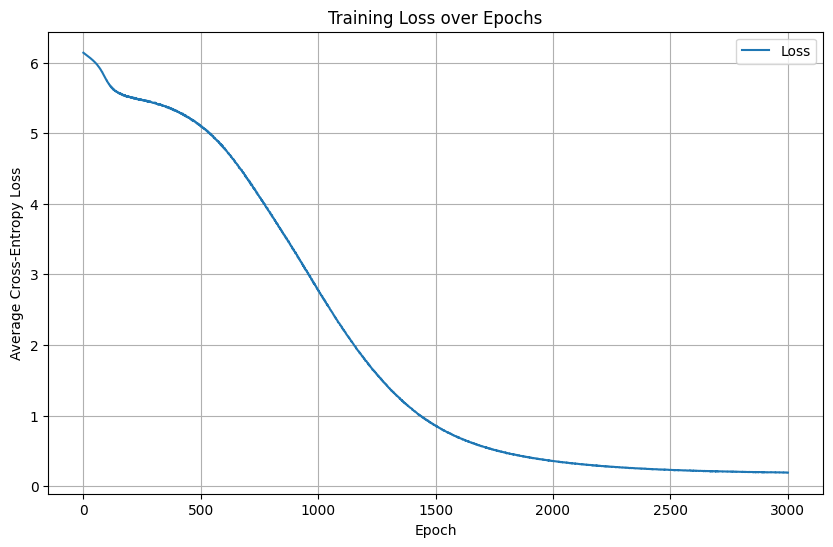

In [ ]:
import matplotlib.pyplot as plt

# 학습 데이터 준비 (n-그램)
def generate_training_data(words, n):
    training_data = []
    for i in range(n, len(words)):
        context = words[i-n:i]
        target = words[i]
        training_data.append((context, target))
    return training_data

training_data = generate_training_data(words, n)
print(f"Total training samples: {len(training_data)}")

# 배치 학습을 위한 데이터 셔플 및 배치 생성 함수
def create_batches(data, batch_size):
    np.random.shuffle(data)
    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if len(batch) == batch_size:
            batches.append(batch)
    return batches

# 학습 루프
loss_history = []

for epoch in range(1, epochs + 1):
    batches = create_batches(training_data, batch_size)
    total_loss = 0.0
    for batch in batches:
        # 배치 데이터 준비
        contexts = [sample[0] for sample in batch]
        targets = [word_to_index[sample[1]] for sample in batch]

        # 컨텍스트 단어 인덱스
        context_indices = np.array([[word_to_index[word] for word in context] for context in contexts], dtype=np.int32)  # (batch_size, n)

        # 임베딩 벡터 추출 및 평탄화
        x = E[context_indices].reshape(batch_size, -1)  # (batch_size, n*D)

        # 순전파: 은닉층 계산
        z_hidden = np.dot(x, W) + b  # (batch_size, H)
        h = relu(z_hidden)           # (batch_size, H)

        # 순전파: 출력층 계산
        z_output = np.dot(h, V_out) + c  # (batch_size, V)
        y_pred = softmax(z_output)       # (batch_size, V)

        # 손실 계산: 교차 엔트로피
        target_one_hot = np.zeros_like(y_pred)
        target_one_hot[np.arange(batch_size), targets] = 1
        loss = -np.sum(target_one_hot * np.log(y_pred + 1e-10)) / batch_size
        total_loss += loss

        # 역전파: 출력층 오차
        delta_o = (y_pred - target_one_hot) / batch_size  # (batch_size, V)

        # 출력층 가중치 및 바이어스 그라디언트
        grad_V_out = np.dot(h.T, delta_o)  # (H, V)
        grad_c = np.sum(delta_o, axis=0)   # (V,)

        # 역전파: 은닉층 오차
        delta_h = np.dot(delta_o, V_out.T) * relu_derivative(z_hidden)  # (batch_size, H)

        # 은닉층 가중치 및 바이어스 그라디언트
        grad_W = np.dot(x.T, delta_h)  # (n*D, H)
        grad_b = np.sum(delta_h, axis=0)  # (H,)

        # 임베딩 층 그라디언트
        grad_E = np.dot(delta_h, W.T).reshape(batch_size, n, embedding_dim)  # (batch_size, n, D)

        # 임베딩 인덱스 확장
        E_updates = context_indices[:, :, np.newaxis]  # (batch_size, n, 1)

        # 임베딩 그라디언트 합산
        grad_E = grad_E.reshape(-1, embedding_dim)  # (batch_size * n, D)
        E_flat = E.reshape(vocab_size, embedding_dim)
        # Accumulate gradients for embedding updates
        E_grad_accum = np.zeros_like(E)
        for i in range(batch_size):
            for j in range(n):
                E_grad_accum[context_indices[i, j]] += grad_E[i * n + j]

        # 가중치 및 바이어스 업데이트
        V_out -= learning_rate * grad_V_out
        c -= learning_rate * grad_c
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b
        E -= learning_rate * E_grad_accum

    # 평균 손실 저장
    avg_loss = total_loss / len(batches)
    loss_history.append(avg_loss)

    # 에포크마다 손실 출력
    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

# 손실 플롯
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Cross-Entropy Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Test

In [ ]:
def predict_next_word(E, W, b, V_out, c, context):
    # 컨텍스트 단어 인덱스
    context_indices = [word_to_index[word] for word in context]
    x = E[context_indices].reshape(1, -1)  # (1, n*D)

    # 순전파: 은닉층 계산
    z_hidden = np.dot(x, W) + b  # (1, H)
    h = relu(z_hidden)           # (1, H)

    # 순전파: 출력층 계산
    z_output = np.dot(h, V_out) + c  # (1, V)
    y_pred = softmax(z_output)       # (1, V)

    # 예측 단어 선택
    predicted_idx = np.argmax(y_pred)
    return index_to_word[predicted_idx]

In [ ]:
# 예제 예측
test_context = ["alice", "was"]
predicted_word = predict_next_word(E, W, b, V_out, c, test_context)
print(f"Context: {test_context}, Predicted next word: {predicted_word}")

Context: ['alice', 'was'], Predicted next word: beginning


In [ ]:
def generate_sentence(E, W, b, V_out, c, start_context, max_length=20):
    context = start_context.copy()
    sentence = start_context.copy()

    for _ in range(max_length):
        predicted_word = predict_next_word(E, W, b, V_out, c, context)
        sentence.append(predicted_word)
        # 컨텍스트 업데이트
        context = context[1:] + [predicted_word]
        # 종료 조건 (예: 마침표)
        if predicted_word.endswith('.'):
            break

    return ' '.join(sentence)

In [ ]:
# 샘플 문장 생성
start_context = ["the", "rabbit-hole"]
generated_sentence = generate_sentence(E, W, b, V_out, c, start_context)
print(f"Generated Sentence: {generated_sentence}")

Generated Sentence: the rabbit-hole alice was beginning to get very tired of sitting by her sister was reading, but it had no idea what


# Code Implementation w/ pytorch

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import math
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split

## Data Load

In [ ]:
# 텍스트 데이터 다운로드 함수
def download_text(url):
    response = urllib.request.urlopen(url)
    raw = response.read().decode('utf-8')
    return raw

# 샘플 텍스트 데이터 다운로드 (Project Gutenberg의 "Alice's Adventures in Wonderland")
url = 'https://www.gutenberg.org/files/11/11-0.txt'
print("Downloading text data...")
text = download_text(url)
print("Download complete.")

# 단어 단위로 분할
words = text.lower().split()
print(f"Total words: {len(words)}")

# 단어 사전 구축
vocab = sorted(list(set(words)))
word_to_index = {word: idx for idx, word in enumerate(vocab)}
index_to_word = {idx: word for idx, word in enumerate(vocab)}
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Download complete.
Total words: 26549
Vocabulary size: 5037


## n-gram (2-gram)

In [ ]:
# 하이퍼파라미터 설정
n = 2  # n-그램의 n 값

# n-그램 생성 함수
def generate_training_data(words, n):
    training_data = []
    for i in range(n, len(words)):
        context = words[i-n:i]
        target = words[i]
        training_data.append((context, target))
    return training_data

training_data = generate_training_data(words, n)
print(f"Total training samples: {len(training_data)}")

Total training samples: 26547


## Dataset Class

In [ ]:
class NGramDataset(Dataset):
    def __init__(self, data, word_to_index, n):
        self.data = data
        self.word_to_index = word_to_index
        self.n = n

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]
        context_idxs = [self.word_to_index[word] for word in context]
        target_idx = self.word_to_index[target]
        return torch.tensor(context_idxs, dtype=torch.long), torch.tensor(target_idx, dtype=torch.long)


## DataLoader

In [ ]:
# 하이퍼파라미터 설정
batch_size = 32

# 데이터셋 생성
train_dataset = NGramDataset(training_data, word_to_index, n)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Modeling

In [ ]:
class NeuralLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n, dropout=0.5):
        super(NeuralLanguageModel, self).__init__()
        self.n = n
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden = nn.Linear(n * embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_dim, vocab_size)

        # Xavier 초기화 적용
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.hidden.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        """
        x: (batch_size, n)
        """
        embed = self.embedding(x)  # (batch_size, n, embedding_dim)
        embed = embed.view(x.size(0), -1)  # (batch_size, n*embedding_dim)
        hidden = self.hidden(embed)  # (batch_size, hidden_dim)
        activated = self.relu(hidden)  # (batch_size, hidden_dim)
        dropped = self.dropout(activated)  # (batch_size, hidden_dim)
        out = self.output(dropped)  # (batch_size, vocab_size)
        return out

## Train

In [ ]:
# 모델 하이퍼파라미터 설정
embedding_dim = 50
hidden_dim = 100
best_loss = float('inf')

# 모델 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralLanguageModel(vocab_size, embedding_dim, hidden_dim, n)
model.to(device)

# 손실 함수 및 최적화기 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# 훈련 루프
epochs = 3000
loss_history = []
accuracy_history = []

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for contexts, targets in train_loader:
        # 데이터를 디바이스로 이동
        contexts, targets = contexts.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(contexts)  # (batch_size, vocab_size)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * contexts.size(0)  # 배치 손실 누적
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()
        total_samples += contexts.size(0)

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples
    loss_history.append(avg_loss)
    accuracy_history.append(avg_accuracy)

    if avg_loss < best_loss:
        best_loss = avg_loss
        # 베스트 모델 저장
        best_model_state = model.state_dict()

    # 에포크마다 손실 및 정확도 출력
    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

# 손실 및 정확도 플롯
plt.figure(figsize=(14, 6))

# 손실 플롯
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

# 정확도 플롯
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch 1/3000, Loss: 7.1097, Accuracy: 0.0649
Epoch 100/3000, Loss: 6.4527, Accuracy: 0.1107
Epoch 200/3000, Loss: 6.3873, Accuracy: 0.1134
Epoch 300/3000, Loss: 6.3731, Accuracy: 0.1161
Epoch 400/3000, Loss: 6.3666, Accuracy: 0.1164


In [ ]:
# 모델 저장
torch.save(best_model_state, 'best_language_model.pth')

# 모델 불러오기
model.load_state_dict(torch.load('best_language_model.pth'))

<ipython-input-30-08d4a1dc0c37>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_language_model.pth'))


<All keys matched successfully>

## Test

In [ ]:
model.load_state_dict(best_model_state)

def generate_sentence(model, start_context, index_to_word, word_to_index, n, device, max_length=20):
    model.eval()
    context = start_context.copy()
    sentence = start_context.copy()

    with torch.no_grad():
        for _ in range(max_length):
            # 컨텍스트 단어 인덱스
            context_idxs = torch.tensor([word_to_index[word] for word in context], dtype=torch.long).unsqueeze(0).to(device)  # (1, n)
            outputs = model(context_idxs)
            y_pred = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(y_pred, 1)
            predicted_word = index_to_word[predicted.item()]
            sentence.append(predicted_word)
            context = context[1:] + [predicted_word]
            if predicted_word.endswith('.'):
                break
    return ' '.join(sentence)

In [ ]:
# 샘플 문장 생성 및 출력
start_context = ["she", "was"]
generated_sentence = generate_sentence(model, start_context, index_to_word, word_to_index, n, device)
print(f"Generated Sentence: {generated_sentence}")

Generated Sentence: she was the the the the the the the the the the the the the the the the the the the the
